![BTS](https://github.com/vfp1/bts-mbds-data-science-foundations-2019/raw/master/sessions/img/Logo-BTS.jpg)

# Session 07: Time Series with Python and TensorFlow
### Victor F. Pajuelo Madrigal <victor.pajuelo@bts.tech> - Advanced Data Analysis (04-05-2020)

Open this notebook in Google Colaboratory: [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vfp1/bts-advanced-data-analysis-2020/blob/master/S07_TimeSeries/07_Advanced_Data_Analysis_TS_TF_NOTsolved.ipynb)

**Resources (code patched, refactored, updated and adapted from):**
* O'Reilly library
* fast.ai
* Aurelien Geron, Hands On Book, 2nd ed
* Yves Hilpisch, Python for Finance
* François Chollet, Keras book


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Basic time series analysis

Here we will use pandas to do simple analysis with financial time series.

In [3]:
import numpy as np
import pandas as pd
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

### Data exploration

#### Data ingestion

We will use financial data from stored CSV files. You can get financial data from APIs that let you get information for free for certain calls



In [4]:
finance_csv = 'https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S07_TimeSeries/financial_data.csv'

In [5]:
data = pd.read_csv(finance_csv, index_col=0, parse_dates=True)

In [6]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1972 entries, 2010-01-04 to 2017-10-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  1972 non-null   float64
 1   MSFT.O  1972 non-null   float64
 2   INTC.O  1972 non-null   float64
 3   AMZN.O  1972 non-null   float64
 4   GS.N    1972 non-null   float64
 5   SPY     1972 non-null   float64
 6   .SPX    1972 non-null   float64
 7   .VIX    1972 non-null   float64
 8   EUR=    1972 non-null   float64
 9   XAU=    1972 non-null   float64
 10  GDX     1972 non-null   float64
 11  GLD     1972 non-null   float64
dtypes: float64(12)
memory usage: 200.3 KB


#### Looking at name titles

In [9]:
instruments = ['Apple Stock', 'Microsoft Stock', 
               'Intel Stock', 'Amazon Stock', 'Goldman Sachs Stock',
               'SPDR S&P 500 ETF Trust', 'S&P 500 Index',
               'VIX Volatility Index', 'EUR/USD Exchange Rate',
               'Gold Price', 'VanEck Vectors Gold Miners ETF',
               'SPDR Gold Trust']

for identifier, name in zip(data.columns, instruments):
    print('{:8s} | {}'.format(identifier, name))

AAPL.O   | Apple Stock
MSFT.O   | Microsoft Stock
INTC.O   | Intel Stock
AMZN.O   | Amazon Stock
GS.N     | Goldman Sachs Stock
SPY      | SPDR S&P 500 ETF Trust
.SPX     | S&P 500 Index
.VIX     | VIX Volatility Index
EUR=     | EUR/USD Exchange Rate
XAU=     | Gold Price
GDX      | VanEck Vectors Gold Miners ETF
GLD      | SPDR Gold Trust


#### Data visualization

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

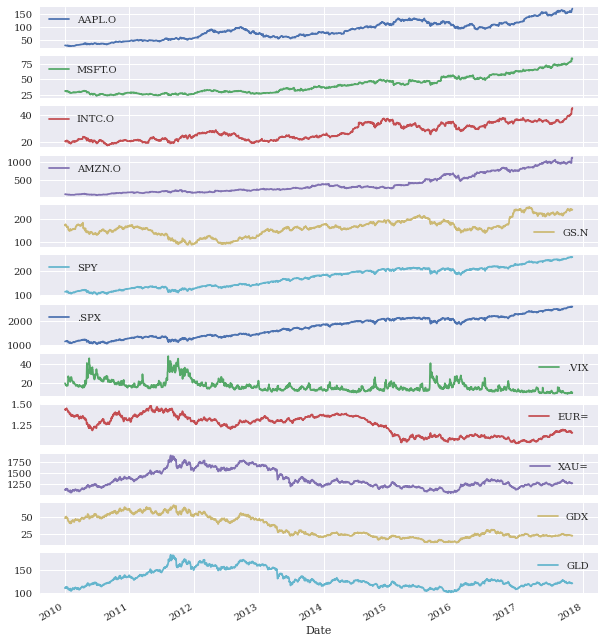

In [8]:
data.plot(figsize=(10, 12), subplots=True)

In [9]:
data.describe().round(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
count,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00,1972.00
mean,86.53,40.59,27.70,401.15,163.61,172.84,1727.54,17.21,1.25,1352.47,34.50,130.60
std,34.04,14.39,5.95,257.12,37.17,42.33,424.35,5.92,0.12,195.38,15.44,19.46
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.19,1.04,1051.36,12.47,100.50
25%,57.57,28.12,22.23,202.66,144.23,132.64,1325.53,13.25,1.13,1214.56,22.22,116.77
50%,84.63,36.54,26.41,306.42,162.09,178.80,1783.81,15.65,1.29,1288.82,26.59,123.90
75%,111.87,50.08,33.74,559.45,184.11,208.01,2080.15,19.20,1.35,1491.98,49.77,145.43
max,169.04,83.89,45.49,1110.85,252.89,257.71,2581.07,48.00,1.48,1897.10,66.63,184.59


In [10]:
data.mean()

AAPL.O      86.530152
MSFT.O      40.586752
INTC.O      27.701411
AMZN.O     401.154006
GS.N       163.614625
SPY        172.835399
.SPX      1727.538342
.VIX        17.209498
EUR=         1.252613
XAU=      1352.471593
GDX         34.499391
GLD        130.601856
dtype: float64

In [11]:
data.aggregate([min, 
                np.mean,
                np.std,
                np.median,
                max]).round(2)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
min,27.44,23.01,17.66,108.61,87.70,102.20,1022.58,9.19,1.04,1051.36,12.47,100.50
mean,86.53,40.59,27.70,401.15,163.61,172.84,1727.54,17.21,1.25,1352.47,34.50,130.60
std,34.04,14.39,5.95,257.12,37.17,42.33,424.35,5.92,0.12,195.38,15.44,19.46
median,84.63,36.54,26.41,306.42,162.09,178.80,1783.81,15.65,1.29,1288.82,26.59,123.90
max,169.04,83.89,45.49,1110.85,252.89,257.71,2581.07,48.00,1.48,1897.10,66.63,184.59


#### Compute changes over time

Statistical analysis methods are often based on changes over time and not the absolute values themselves. There are multiple options to calculate the changes in a time series over time, including absolute differences, percentage changes, and logarithmic (log) returns.

For that we can use Pandas method to compute absolute differences using the `diff()` method:

In [13]:
data.head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.90,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37


In [14]:
data.iloc[1]['AAPL.O']

30.625683660000004

In [15]:
data.iloc[0]['AAPL.O']

30.57282657

In [15]:
data.iloc[1]['AAPL.O'] - data.iloc[0]['AAPL.O']

0.05285709000000338

In [16]:
# Diff computes the difference between one value and its previous one
data.diff().head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.052857,0.010,-0.01,0.79,3.06,0.30,3.53,-0.69,-0.0043,-1.35,0.46,-0.10
2010-01-06,-0.487142,-0.190,-0.07,-2.44,-1.88,0.08,0.62,-0.19,0.0044,19.85,1.17,1.81
2010-01-07,-0.055714,-0.318,-0.20,-2.25,3.41,0.48,4.55,-0.10,-0.0094,-6.60,-0.24,-0.69
2010-01-08,0.200000,0.208,0.23,3.52,-3.36,0.38,3.29,-0.93,0.0094,4.20,0.74,0.55


In [17]:
data.diff().mean()

AAPL.O    0.070252
MSFT.O    0.026499
INTC.O    0.012486
AMZN.O    0.492836
GS.N      0.035211
SPY       0.072968
.SPX      0.731745
.VIX     -0.005003
EUR=     -0.000140
XAU=      0.076712
GDX      -0.012801
GLD       0.005515
dtype: float64

From a statistics point of view, absolute changes are not optimal because they are dependent on the scale of the time series data itself. Therefore, percentage changes are usually preferred. The following code derives the percentage changes or percentage returns (also: simple returns) in a financial context and visualizes their mean values per column

In [18]:
data.pct_change().round(3).head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,0.000,-0.000,0.006,0.018,0.003,0.003,-0.034,-0.003,-0.001,0.010,-0.001
2010-01-06,-0.016,-0.006,-0.003,-0.018,-0.011,0.001,0.001,-0.010,0.003,0.018,0.024,0.016
2010-01-07,-0.002,-0.010,-0.010,-0.017,0.020,0.004,0.004,-0.005,-0.007,-0.006,-0.005,-0.006
2010-01-08,0.007,0.007,0.011,0.027,-0.019,0.003,0.003,-0.049,0.007,0.004,0.015,0.005


<AxesSubplot:>

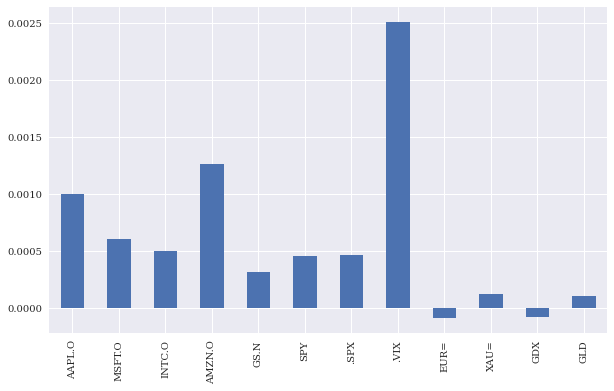

In [19]:
data.pct_change().mean().plot(kind='bar', figsize=(10, 6))

As an alternative to percentage returns, log returns can be used. In some scenarios, they are easier to handle and therefore often preferred in a financial context.

We can easily create the cumulative log returns for the single financial time series. This type of plot leads to some form of normalization:

In [20]:
rets = np.log(data / data.shift(1))
rets.head().round(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.002,0.000,-0.000,0.006,0.018,0.003,0.003,-0.035,-0.003,-0.001,0.010,-0.001
2010-01-06,-0.016,-0.006,-0.003,-0.018,-0.011,0.001,0.001,-0.010,0.003,0.018,0.024,0.016
2010-01-07,-0.002,-0.010,-0.010,-0.017,0.019,0.004,0.004,-0.005,-0.007,-0.006,-0.005,-0.006
2010-01-08,0.007,0.007,0.011,0.027,-0.019,0.003,0.003,-0.050,0.007,0.004,0.015,0.005


<AxesSubplot:xlabel='Date'>

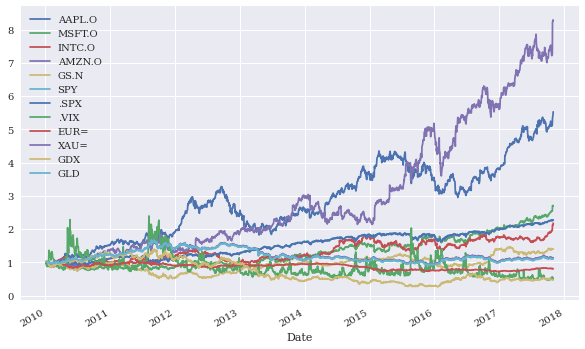

In [21]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6))

#### Resampling
Resampling is an important operation on financial time series data. Usually this takes the form of downsampling, meaning that, for example, a tick data series is resampled to one-minute intervals or a time series with daily observations is resampled to one with weekly or monthly observations

In [22]:
# Weekly resample
data.resample('1w', label='right').last().head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-10,30.282827,30.66,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.10,49.84,111.37
2010-01-17,29.418542,30.86,20.80,127.14,165.21,113.64,1136.03,17.91,1.4382,1129.90,47.42,110.86
2010-01-24,28.249972,28.96,19.91,121.43,154.12,109.21,1091.76,27.31,1.4137,1092.60,43.79,107.17
2010-01-31,27.437544,28.18,19.40,125.41,148.72,107.39,1073.87,24.62,1.3862,1081.05,40.72,105.96
2010-02-07,27.922829,28.02,19.47,117.39,154.16,106.66,1066.19,26.11,1.3662,1064.95,42.41,104.68


In [23]:
# Monthly resample
data.resample('1m', label='right').last().head()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-31,27.437544,28.1800,19.40,125.41,148.72,107.3900,1073.87,24.62,1.3862,1081.05,40.72,105.960
2010-02-28,29.231399,28.6700,20.53,118.40,156.35,110.7400,1104.49,19.50,1.3625,1116.10,43.89,109.430
2010-03-31,33.571395,29.2875,22.29,135.77,170.63,117.0000,1169.43,17.59,1.3510,1112.80,44.41,108.950
2010-04-30,37.298534,30.5350,22.84,137.10,145.20,118.8125,1186.69,22.05,1.3295,1178.25,50.51,115.360
2010-05-31,36.697106,25.8000,21.42,125.46,144.26,109.3690,1089.41,32.07,1.2267,1213.81,49.86,118.881


<AxesSubplot:xlabel='Date'>

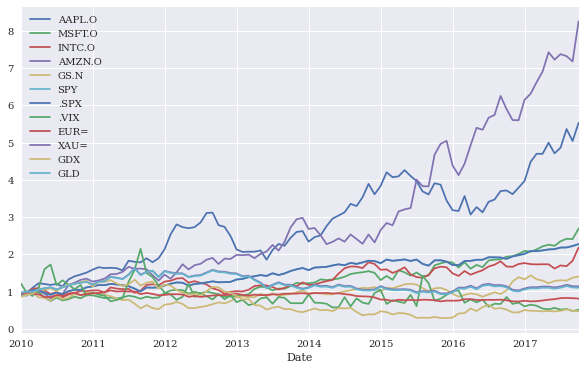

In [24]:
"""
The cumsum() method is called, then np.exp() is applied to the results, then we resample
"""
rets.cumsum().apply(np.exp).resample('1m', label='right').last().plot(figsize=(10, 6))

## Rolling statistics

It is financial tradition to work with rolling statistics, often also called financial indicators or financial studies. 

Such rolling statistics are basic tools for financial chartists and technical traders, for example. We will work here with single financial time series only.

In [32]:
sym = 'AAPL.O'
data = pd.DataFrame(data[sym]).dropna()
data.tail()

,AAPL.O
Date,
2017-10-25,156.41
2017-10-26,157.41
2017-10-27,163.05
2017-10-30,166.72
2017-10-31,169.04


### Pandas usage

In [33]:
# We need to define a window size, that is, the number of index values to include
window = 20

<AxesSubplot:xlabel='Date'>

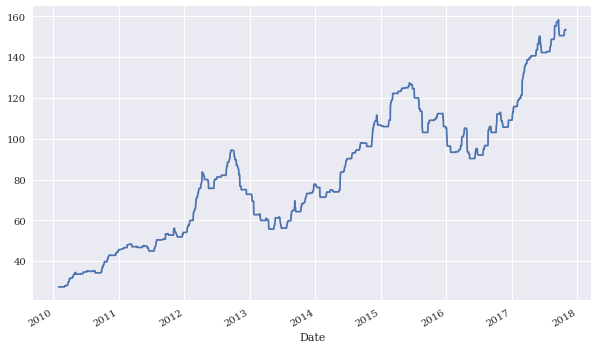

In [34]:
# Rolling minimum value of stock
data['min'] = data[sym].rolling(window=window).min()
data['min'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

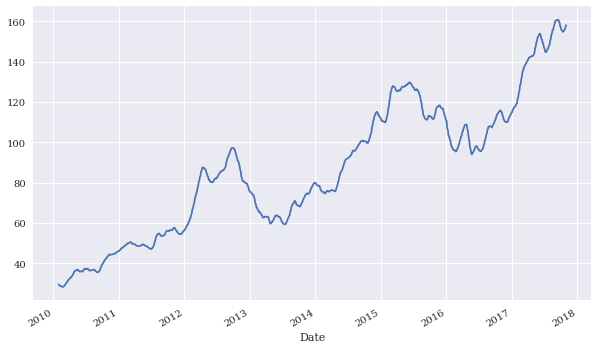

In [43]:
# Rolling mean value of stock
data['mean'] = data[sym].rolling(window=window).mean()
data['mean'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

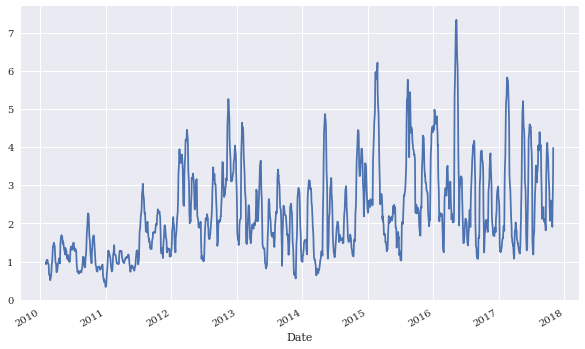

In [44]:
# Rolling standard deviation of stock
data['std'] = data[sym].rolling(window=window).std()
data['std'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

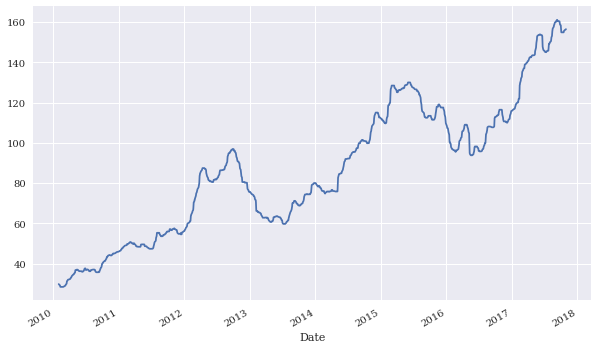

In [45]:
# Rolling median value of stock
data['median'] = data[sym].rolling(window=window).median()
data['median'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

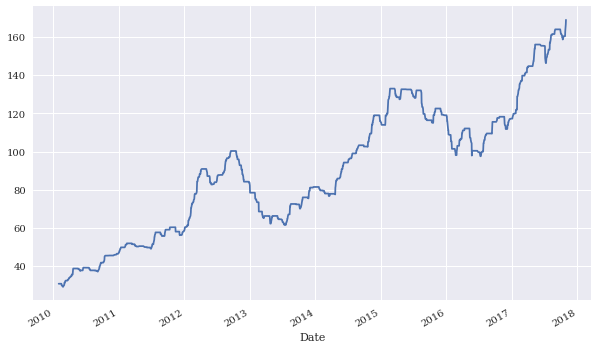

In [46]:
# Rolling max value of stock
data['max'] = data[sym].rolling(window=window).max()
data['max'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

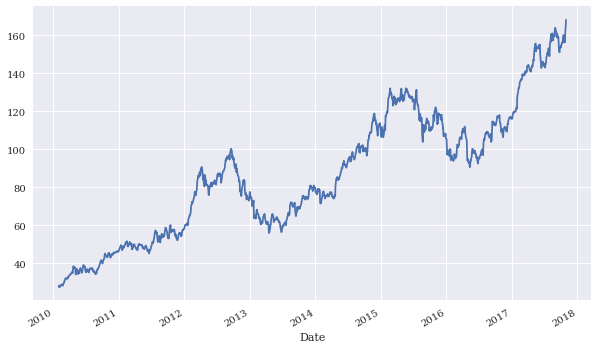

In [47]:
# Rolling Exponential Weighted moving average value of stock
# It has a decay of 
data['ewma'] = data[sym].ewm(halflife=0.5, min_periods=window).mean()
data['ewma'].plot(figsize=(10, 6))

<AxesSubplot:xlabel='Date'>

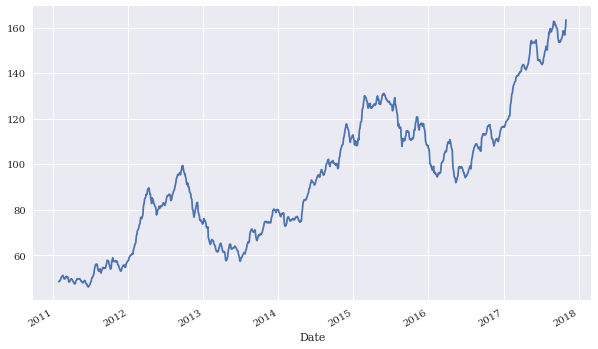

In [61]:
data['ewma_1'] = data[sym].ewm(halflife=2, min_periods=window).mean()
data['ewma_1'].plot(figsize=(10, 6))

In [48]:
data.dropna().head()

,AAPL.O,min,std,median,max,ewma,mean
Date,,,,,,,
2010-02-01,27.818544,27.437544,0.933650,29.821542,30.719969,27.805432,29.580892
2010-02-02,27.979972,27.437544,0.968048,29.711113,30.719969,27.936337,29.451249
2010-02-03,28.461400,27.437544,0.950665,29.685970,30.719969,28.330134,29.343035
2010-02-04,27.435687,27.435687,1.021129,29.547113,30.719969,27.659299,29.207892
2010-02-05,27.922829,27.435687,1.037811,29.419256,30.719969,27.856947,29.099892


Rolling statistis for minimum, mean and maximum values

<AxesSubplot:xlabel='Date'>

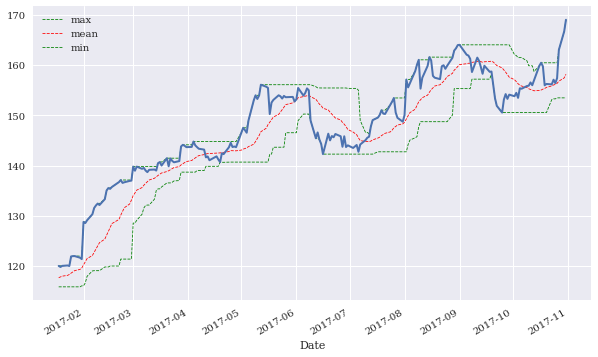

In [51]:
ax = data[['max', 'mean', 'min']].iloc[-200:].plot(figsize=(10, 6), style=['g--', 'r--', 'g--'], lw=0.8)
data[sym].iloc[-200:].plot(ax=ax, lw=2.0)

<AxesSubplot:xlabel='Date'>

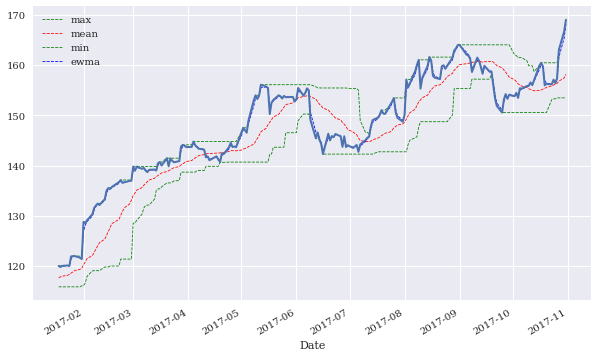

In [52]:
ax = data[['max', 'mean', 'min', 'ewma']].iloc[-200:].plot(figsize=(10, 6), style=['g--', 'r--', 'g--', 'b--'], lw=0.8)
data[sym].iloc[-200:].plot(ax=ax, lw=2.0)

## Technical analysis

Rolling statistics are a major tool in the so-called technical analysis of stocks, as compared to the fundamental analysis which focuses, for instance, on financial reports and the strategic positions of the company whose stock is being analyzed.

A decades-old trading strategy based on technical analysis is using two simple moving averages (SMAs). The idea is that the trader should go long (BUY) on a stock (or financial instrument in general) when the shorter-term SMA is above the longer-term SMA and should go short (SELL) when the opposite holds true. The concepts can be made precise with pandas and the capabilities of the `DataFrame` object.

Rolling statistics are generally only calculated when there is enough data given the window parameter specification. For instance, below the SMA time series only start at the day for which there is enough data given the specific parameterization:

In [53]:
data['SMA1'] = data[sym].rolling(window=42).mean()

In [54]:
data['SMA2'] = data[sym].rolling(window=252).mean()

In [55]:
data.dropna().head()

,AAPL.O,min,std,median,max,ewma,mean,SMA1,SMA2
Date,,,,,,,,,
2010-12-31,46.079954,45.348526,0.336271,45.922811,46.495668,46.133644,45.986686,45.280967,37.120735
2011-01-03,47.081381,45.458526,0.383162,45.991383,47.081381,46.844447,46.073329,45.349708,37.186246
2011-01-04,47.327096,45.458526,0.465705,46.054954,47.327096,47.206433,46.152900,45.412599,37.252521
2011-01-05,47.714238,45.679597,0.553550,46.154240,47.714238,47.587287,46.265686,45.466102,37.322266
2011-01-06,47.675667,45.679597,0.627405,46.232811,47.714238,47.653572,46.356543,45.522565,37.392079


In [56]:
data[[sym, 'SMA1', 'SMA2']].tail()

,AAPL.O,SMA1,SMA2
Date,,,
2017-10-25,156.41,157.610952,139.862520
2017-10-26,157.41,157.514286,140.028472
2017-10-27,163.05,157.517619,140.221210
2017-10-30,166.72,157.597857,140.431528
2017-10-31,169.04,157.717857,140.651766


<AxesSubplot:xlabel='Date'>

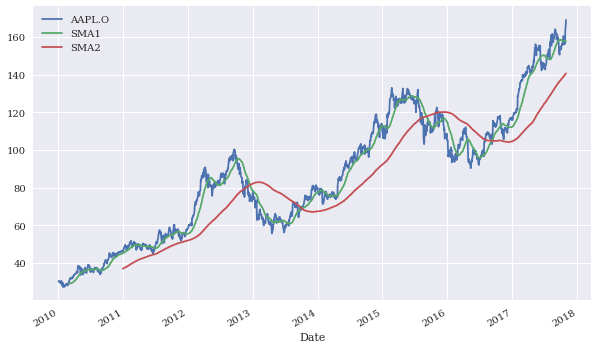

In [57]:
data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6))

The SMAs are only a means to an end. They are used to derive positions to implement a trading strategy. For instance, we can take decisions on long/short positions. The figure below visualizes a long position by a value of 1 and a short position by a value of -1. The change in the position is triggered (visually) by a crossover of the two lines representing the SMA time series:

In [58]:
data.dropna(inplace=True)
data['positions'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
data.head()

,AAPL.O,min,std,median,max,ewma,mean,SMA1,SMA2,positions
Date,,,,,,,,,,
2010-12-31,46.079954,45.348526,0.336271,45.922811,46.495668,46.133644,45.986686,45.280967,37.120735,1
2011-01-03,47.081381,45.458526,0.383162,45.991383,47.081381,46.844447,46.073329,45.349708,37.186246,1
2011-01-04,47.327096,45.458526,0.465705,46.054954,47.327096,47.206433,46.152900,45.412599,37.252521,1
2011-01-05,47.714238,45.679597,0.553550,46.154240,47.714238,47.587287,46.265686,45.466102,37.322266,1
2011-01-06,47.675667,45.679597,0.627405,46.232811,47.714238,47.653572,46.356543,45.522565,37.392079,1


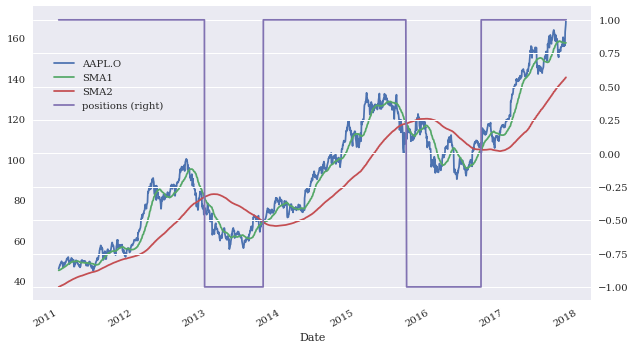

In [59]:
ax = data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(10, 6), secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))

The trading strategy implicitly derived here only leads to a few trades per se: only when the position value changes (i.e., a crossover happens) does a trade take place. Including opening and closing trades, this would add up to just six trades in total.

## 🏋️🏋️ IN CLASS EXERCISE 1

Take another symbol from the dataset given and create a simple moving average strategy. How many trades did you reached?

## Correlation analysis

As a further illustration of how to work with pandas and financial time series data, consider the case of the S&P 500 stock index and the VIX volatility index. It is a stylized fact that when the S&P 500 rises, the VIX falls in general, and vice versa. This is about correlation and not causation. This section shows how to come up with some supporting statistical evidence for the stylized fact that the S&P 500 and the VIX are (highly) negatively correlated

### Data ingestion

In [62]:
data_finance = pd.read_csv(finance_csv, index_col=0, parse_dates=True)
data_finance = data_finance[['.SPX', '.VIX']].dropna()

In [63]:
data_finance.head()

,.SPX,.VIX
Date,,
2010-01-04,1132.99,20.04
2010-01-05,1136.52,19.35
2010-01-06,1137.14,19.16
2010-01-07,1141.69,19.06
2010-01-08,1144.98,18.13


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

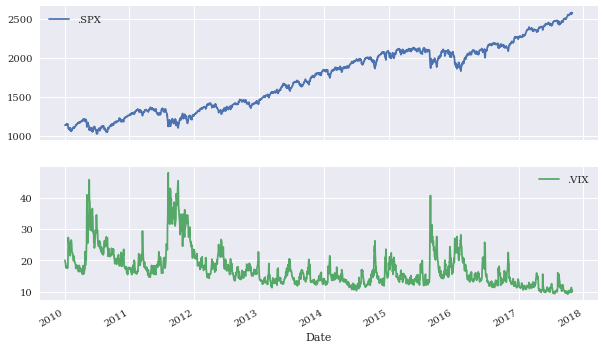

In [64]:
data_finance.plot(subplots=True, figsize=(10,6))

### Data exploration

When plotting (parts of) the two time series in a single plot and with adjusted scalings, the stylized fact of negative correlation between the two indices becomes evident through simple visual inspection

<AxesSubplot:xlabel='Date'>

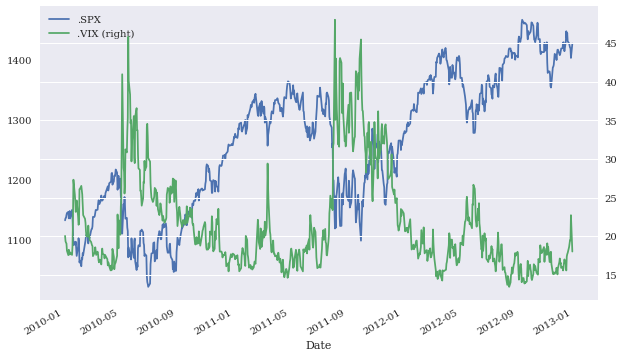

In [65]:
data_finance.loc[:'2012-12-31'].plot(secondary_y='.VIX', figsize=(10, 6))

As pointed out earlier, statistical analysis in general relies on returns instead of absolute changes or even absolute values. Therefore, we’ll calculate log returns first before any further analysis takes place. Below we depict the high variability of the log returns over time. For both indices so-called “volatility clusters” can be spotted. In general, periods of high volatility in the stock index are accompanied by the same phenomena in the volatility index:

In [66]:
rets = np.log(data_finance / data_finance.shift(1))
rets.head()

,.SPX,.VIX
Date,,
2010-01-04,NaN,NaN
2010-01-05,0.003111,-0.035038
2010-01-06,0.000545,-0.009868
2010-01-07,0.003993,-0.005233
2010-01-08,0.002878,-0.050024


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

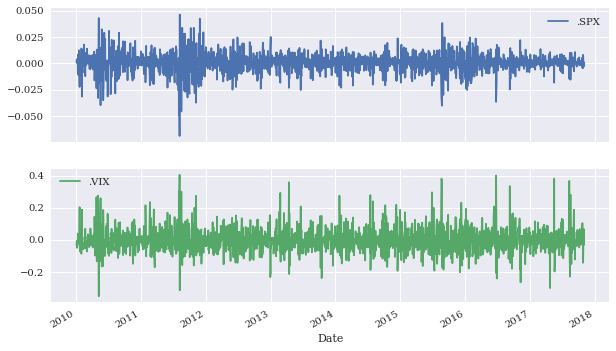

In [67]:
rets.dropna(inplace=True)
rets.plot(subplots=True, figsize=(10, 6))

This is extremely hard to understand the correlation in between both graphs. Maybe we can try a scatterplot?


array([[<AxesSubplot:xlabel='.SPX', ylabel='.SPX'>,
        <AxesSubplot:xlabel='.VIX', ylabel='.SPX'>],
       [<AxesSubplot:xlabel='.SPX', ylabel='.VIX'>,
        <AxesSubplot:xlabel='.VIX', ylabel='.VIX'>]], dtype=object)

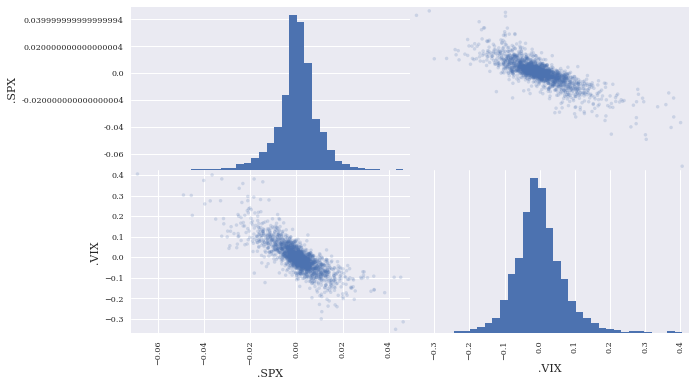

In [68]:
pd.plotting.scatter_matrix(rets,
                           alpha=0.2,
                           diagonal='hist',
                           hist_kwds={'bins': 35},
                           figsize=(10, 6))

We can see now that both timeseries are negatively correlated

### Regression analysis
We can implement an ordinary least-squares (OLS) regression analysis. This shows a scatter plot of the log returns and the linear regression line through the cloud of dots. The slope is obviously negative, providing support for the stylized fact about the negative correlation between the two indices

In [69]:
reg = np.polyfit(rets['.SPX'], rets['.VIX'], deg=1)

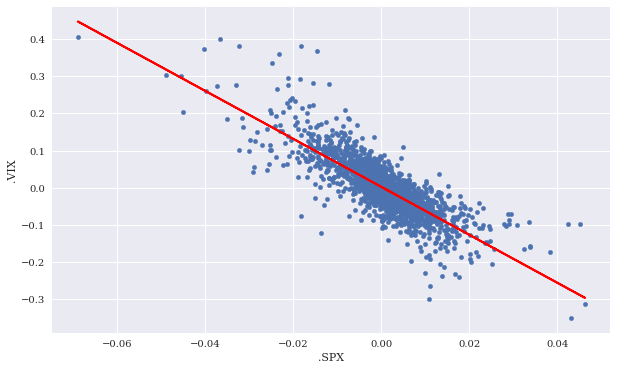

In [70]:
ax = rets.plot(kind='scatter', x='.SPX', y='.VIX', figsize=(10, 6))
ax.plot(rets['.SPX'], np.polyval(reg, rets['.SPX']), 'r', lw=2)

### Correlation

We can represent correlation in two ways:

*   The static one that takes into account the whole dataset (red line, the corr() value
*   A rolling one showing the correlation for a fixed window over time. The correlation varies over time, but tends to be always negative

This provides strong support for the stylized fact that the S&P 500 and the VIX indices are (strongly) negatively correlated. So we could track VIX to trade on S&P 500

In [71]:
rets.corr()

,.SPX,.VIX
.SPX,1.000000,-0.808372
.VIX,-0.808372,1.000000


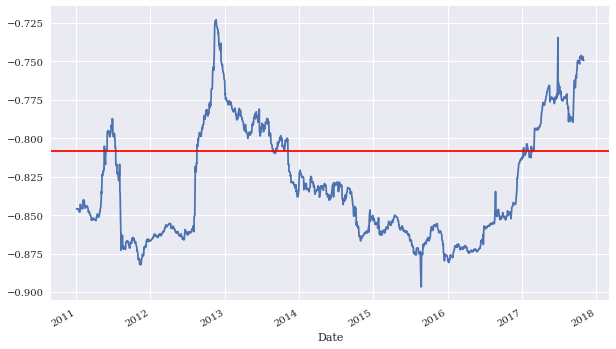

In [72]:
ax = rets['.SPX'].rolling(window=252).corr(rets['.VIX']).plot(figsize=(10, 6))
ax.axhline(rets.corr().iloc[0, 1], c='r')

# Introduction to RNNs

Recurrent Neural Networks are a type of network that can predict the future (*up to a certain point* 😅)

---
🚩 **DISCLAIMER** - *As always you will see properly how an RNN works within the Deep Learning class. Here we learn how to use them for the task of forecasting time series*

---

Recurrent Neural Networks can...

* Analyze time series data such as **stock prices**, and tell you when to buy or sell. 
* In autonomous driving systems, they can **anticipate car trajectories** and help avoid accidents. 
* They can work on **sequences of arbitrary lengths**, rather than on fixed-sized inputs like all the nets we have seen (perhaps not the market ones). 
* They can take sentences, documents, or audio samples as input, making them extremely useful for **natural language processing** applications such as automatic translation or speech-to-text.

RNNs are not the only types of neural networks capable of handling sequential data: 

* For *small sequences*, a regular dense network can do the trick
* For *very long sequences*, such as audio samples or text, convolutional neural networks can actually work quite well too. 
    * You will also see in Deep Learning class how Wavenet works on that regard








## The recurrent neuron

We have been focusing on **feedforward neural networks**, meaning that **activations flow only in one direction,** from the input layer to the output layer.

A recurrent neural network looks very much like a feedforward neural network, except **it also has connections pointing backward**. Let’s look at the simplest possible RNN, composed of one neuron receiving inputs, producing an output, and sending that output back to itself.

At each time step `t` (also called a frame), this recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y(t–1)$. Since there is no previous output at the first time step, it is generally set to 0.

![alt text](https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S07_TimeSeries/mls2_1501.png)

---
You can easily create a layer of recurrent neurons. At each time step `t`, every neuron receives both the input vector $x(t)$ and the output vector from the previous time step $y(t–1)$.


![alt text](https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S07_TimeSeries/mls2_1502.png)

Each recurrent neuron has two sets of weights: one for the inputs $x(t)$ and the other for the outputs of the previous time step, $y(t–1)$.

## Backpropagation through time

To train an RNN, the trick is to unroll it through time and then simply use regular backpropagation. This strategy is called backpropagation through time (BPTT).

Just like in regular backpropagation, there is a first forward pass through the unrolled network (represented by the dashed arrows). Then the output sequence is evaluated using a cost function $C(Y(0), Y(1), …Y(T))$ (where $T$ is the max time step).

The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows). 

Finally the model parameters are updated using the gradients computed during BPTT. 

![alt text](https://raw.githubusercontent.com/vfp1/bts-advanced-data-analysis-2020/master/S07_TimeSeries/mls2_1505.png)

## Note on Deep RNNs

To implement a simple RNN is easy:



In [73]:
model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

However, if we need to predict complex time series. It is bettwer to use LSTM, since it has memory cell capabilities. SimpleRNN has also feedback loops, but LSTM can maintain memory for longer periods of time.


---
**RNN**: recurrent neural network

![alt text](https://i.stack.imgur.com/02KvP.png)

---
**LSTM**: long-short term memory
![alt text](https://i.stack.imgur.com/jyoNj.png)


To create a Deep RNN, one just need to stack layers after another:

In [0]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

⚠️⚠️⚠️ **WARNING!** Make sure to set `return_sequences=True` for all recurrent layers (except the last one, if you only care about the last output). If you don’t, they will output a 2D array (containing only the output of the last time step) instead of a 3D array (containing outputs for all time steps), and the next recurrent layer will complain that you are not feeding it sequences in the expected 3D format.

Also the last layer (Dense) needs to accomodate to the lenght of the sequence to be predicted. In this case will be univariate time series analysis (only 1 variable)

## Note on shapes

⚠️⚠️⚠️ **WARNING!** When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape `[batch size, time steps, dimensionality]`, where dimensionality is 1 for univariate time series and more for multivariate time series.

So you will need to write functions to accomodate usually 2D arrays into 3D arrays.

## Note on Seasonality

There are many other models to forecast time series, such as weighted moving average models or autoregressive integrated moving average (ARIMA) models. Some of them require you to first remove the trend and seasonality. 

For example, if you are studying the number of active users on your website, and it is growing by 10% every month, you would have to remove this trend from the time series. Once the model is trained and starts making predictions, you would have to add the trend back to get the final predictions. 

Similarly, if you are trying to predict the amount of sunscreen lotion sold every month, you will probably observe strong seasonality: since it sells well every summer, a similar pattern will be repeated every year. 

You would have to remove this seasonality from the time series, for example by computing the difference between the value at each time step and the value one year earlier (this technique is called differencing). We have seen this just before. 

Again, after the model is trained and makes predictions, you would have to add the seasonal pattern back to get the final predictions.

When using RNNs, it is generally not necessary to do all this, but it may improve performance in some cases, since the model will not have to learn the trend or the seasonality.

# Time series forecasting with RNNs ⌛🔮🔮

We call **time series** to those cases where the data will be a sequence of one or more values per time step. 

When we have a single value per time step, we call these are **univariate time series**. For instance, in the one that we used the AAPL.O stock with other variables, we have multiple values per time step, so it is a **multivariate time series**. 

A typical task is to predict future values, which is called **forecasting**. Another common task is to fill in the blanks: to predict (or rather “postdict”) missing values from the past. This is called **imputation**. 

## ⌛ Univariate time series

Univariate time series are time series that have only one variable, and we need to predict it. We will use the dataset with the Apple stocks.

In [83]:
# Adding this so we get consistency between runs
tf.random.set_seed(13)

### Data preparation

In [84]:
data.head()

,AAPL.O,min,std,median,max,ewma,mean,SMA1,SMA2,positions,ewma_1
Date,,,,,,,,,,,
2010-12-31,46.079954,45.348526,0.336271,45.922811,46.495668,46.133644,45.986686,45.280967,37.120735,1,NaN
2011-01-03,47.081381,45.458526,0.383162,45.991383,47.081381,46.844447,46.073329,45.349708,37.186246,1,NaN
2011-01-04,47.327096,45.458526,0.465705,46.054954,47.327096,47.206433,46.152900,45.412599,37.252521,1,NaN
2011-01-05,47.714238,45.679597,0.553550,46.154240,47.714238,47.587287,46.265686,45.466102,37.322266,1,NaN
2011-01-06,47.675667,45.679597,0.627405,46.232811,47.714238,47.653572,46.356543,45.522565,37.392079,1,NaN


In [85]:
data['AAPL.O']

Date
2010-12-31     46.079954
2011-01-03     47.081381
2011-01-04     47.327096
2011-01-05     47.714238
2011-01-06     47.675667
                 ...    
2017-10-25    156.410000
2017-10-26    157.410000
2017-10-27    163.050000
2017-10-30    166.720000
2017-10-31    169.040000
Name: AAPL.O, Length: 1721, dtype: float64

#### Create data split

In [86]:
# Create train split with 20%
train_split_finance = int(data['AAPL.O'].shape[0] - data['AAPL.O'].shape[0]*.2)
train_split_finance

1376

#### Scale the data

In [87]:
from sklearn.preprocessing import StandardScaler

In [88]:
data_apple = data[['AAPL.O']]
data_apple

,AAPL.O
Date,
2010-12-31,46.079954
2011-01-03,47.081381
2011-01-04,47.327096
2011-01-05,47.714238
2011-01-06,47.675667
...,...
2017-10-25,156.410000
2017-10-26,157.410000
2017-10-27,163.050000


In [89]:
scaler = StandardScaler()
finance_uni_data = scaler.fit_transform(data_apple.values)

In [90]:
finance_uni_data

array([[-1.57599233],
       [-1.54287879],
       [-1.53475393],
       ...,
       [ 2.29177794],
       [ 2.41313137],
       [ 2.48984526]])

#### Create univariate dataset maker

Our dataset provides us data saying that every trading date we have a market value for the stock.

Given a specific time, **let's say you want to predict the price of the stock 6 days in the future**. In order to make this prediction, **you choose to use 30 days of observations**. Thus, you would **create a window containing the last 30 observations to train the model**. 

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the **size of the past window of information**. The `target_size` is **how far in the future** does the model need to learn to predict. The `target_size` is the label that needs to be predicted.

In [91]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    """
    """
    data = []
    labels = []


    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [92]:
univariate_past_history = 20
univariate_future_target = 0

x_train_finance_uni, y_train_finance_uni = univariate_data(dataset=finance_uni_data, 
                                           start_index=0,
                                           end_index=train_split_finance,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)

x_val_finance_uni, y_val_finance_uni = univariate_data(dataset=finance_uni_data,
                                       start_index=train_split_finance, 
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [93]:
x_train_finance_uni.shape

(1356, 20, 1)

In [94]:
y_train_finance_uni.shape

(1356, 1)

In [95]:
# With inverse transform we can unscale the data
print ('Single window of past history')
print (scaler.inverse_transform(x_train_finance_uni)[0])
print ('\n Target stock price to predict')
print (scaler.inverse_transform(y_train_finance_uni)[0])

Single window of past history
[[46.07995392]
 [47.08138149]
 [47.32709553]
 [47.714238  ]
 [47.67566661]
 [48.01709484]
 [48.92209393]
 [48.80566548]
 [49.20280794]
 [49.38280776]
 [49.78280736]
 [48.66423705]
 [48.40566588]
 [47.52566676]
 [46.67423904]
 [48.20709465]
 [48.7713798 ]
 [49.12137945]
 [49.02995097]
 [48.0142377 ]]

 Target stock price to predict
[48.47423724]


#### Visualization

In [96]:
def create_time_steps(length):
  return list(range(-length, 0))

In [97]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'ro', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

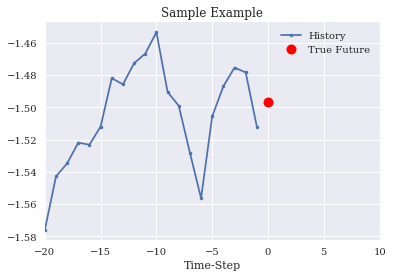

In [98]:
show_plot([x_train_finance_uni[0], y_train_finance_uni[0]], 0, 'Sample Example')

### Baseline prediction

We could try to predict what will happen by exploring the mean of the dataset

In [99]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

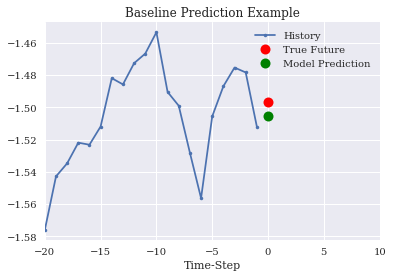

In [100]:
show_plot([x_train_finance_uni[0], y_train_finance_uni[0], baseline(x_train_finance_uni[0])], 0,
           'Baseline Prediction Example')

### Creating an RNN

Let's try to predict by using a RNN. We will use `tf.data` to shuffle, batch and cache the dataset.

In [101]:
y_train_finance_uni

array([[-1.49682216],
       [-1.46984951],
       [-1.47320338],
       ...,
       [ 0.12593326],
       [ 0.052526  ],
       [ 0.04492075]])

In [102]:
BATCH_SIZE = 32
BUFFER_SIZE = 100

train_univariate_finance = tf.data.Dataset.from_tensor_slices((x_train_finance_uni, y_train_finance_uni))
train_univariate_finance = train_univariate_finance.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate_finance = tf.data.Dataset.from_tensor_slices((x_val_finance_uni, y_val_finance_uni))
val_univariate_finance = val_univariate_finance.batch(BATCH_SIZE).repeat()

#### Creating the model

In [103]:
x_train_finance_uni.shape[-2:]

(20, 1)

In [104]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_finance_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to just check the output of the model

In [105]:
for x, y in val_univariate_finance.take(1):
    print(x)
    print(y)
    print(simple_lstm_model.predict(x).shape)

tf.Tensor(
[[[ 0.07170447]
  [ 0.05980059]
  [ 0.07798708]
  [-0.01129202]
  [-0.05626223]
  [-0.00500941]
  [ 0.02177431]
  [ 0.06145391]
  [ 0.07104315]
  [ 0.04128345]
  [ 0.05913927]
  [ 0.07269646]
  [ 0.09716555]
  [ 0.10708545]
  [ 0.12163463]
  [ 0.10344815]
  [ 0.16693551]
  [ 0.16660484]
  [ 0.20132449]
  [ 0.20264714]]

 [[ 0.05980059]
  [ 0.07798708]
  [-0.01129202]
  [-0.05626223]
  [-0.00500941]
  [ 0.02177431]
  [ 0.06145391]
  [ 0.07104315]
  [ 0.04128345]
  [ 0.05913927]
  [ 0.07269646]
  [ 0.09716555]
  [ 0.10708545]
  [ 0.12163463]
  [ 0.10344815]
  [ 0.16693551]
  [ 0.16660484]
  [ 0.20132449]
  [ 0.20264714]
  [ 0.20562311]]

 [[ 0.07798708]
  [-0.01129202]
  [-0.05626223]
  [-0.00500941]
  [ 0.02177431]
  [ 0.06145391]
  [ 0.07104315]
  [ 0.04128345]
  [ 0.05913927]
  [ 0.07269646]
  [ 0.09716555]
  [ 0.10708545]
  [ 0.12163463]
  [ 0.10344815]
  [ 0.16693551]
  [ 0.16660484]
  [ 0.20132449]
  [ 0.20264714]
  [ 0.20562311]
  [ 0.18809796]]

 [[-0.01129202]
  [-0.0

(32, 1)


In [108]:
val_univariate_finance

<RepeatDataset shapes: ((None, 20, 1), (None, 1)), types: (tf.float64, tf.float64)>

### Train the model

In [106]:
EVALUATION_INTERVAL = 50
EPOCHS = 10

history_simple = simple_lstm_model.fit(train_univariate_finance, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate_finance, validation_steps=50)

Epoch 1/10
50/50 [==============================] - 9s 74ms/step - loss: 0.7765 - val_loss: 0.9795
Epoch 2/10
50/50 [==============================] - 2s 43ms/step - loss: 0.2594 - val_loss: 0.7406
Epoch 3/10
50/50 [==============================] - 2s 35ms/step - loss: 0.1944 - val_loss: 0.6821
Epoch 4/10
50/50 [==============================] - 1s 28ms/step - loss: 0.1774 - val_loss: 0.6520
Epoch 5/10
50/50 [==============================] - 1s 10ms/step - loss: 0.1855 - val_loss: 0.6160
Epoch 6/10
50/50 [==============================] - 1s 10ms/step - loss: 0.1456 - val_loss: 0.5531
Epoch 7/10
50/50 [==============================] - 1s 10ms/step - loss: 0.1265 - val_loss: 0.5130
Epoch 8/10
50/50 [==============================] - 1s 10ms/step - loss: 0.0876 - val_loss: 0.4877
Epoch 9/10
50/50 [==============================] - 0s 10ms/step - loss: 0.0877 - val_loss: 0.4630
Epoch 10/10
50/50 [==============================] - 1s 16ms/step - loss: 0.0782 - val_loss: 0.4330


<AxesSubplot:>

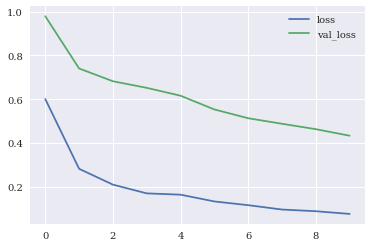

In [107]:
hist_df_uni = pd.DataFrame(history_simple.history)
hist_df_uni.plot()

### Predict the model

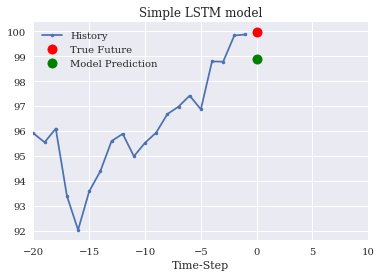

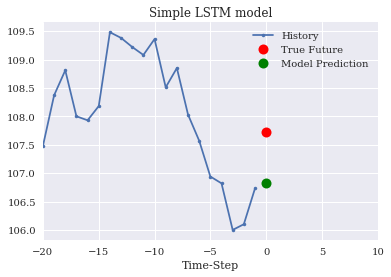

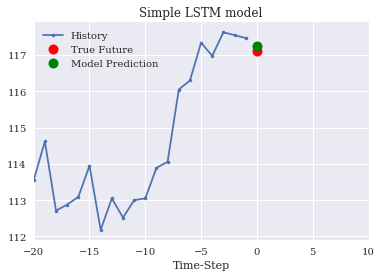

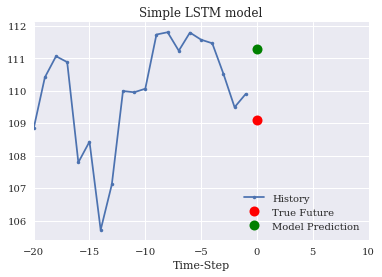

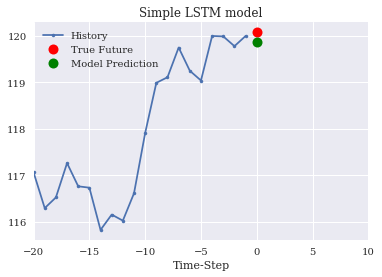

In [220]:
for x, y in val_univariate_finance.take(5):
  plot = show_plot([scaler.inverse_transform(x[0].numpy()), scaler.inverse_transform(y[0].numpy()),
                    scaler.inverse_transform(simple_lstm_model.predict(x)[0])], 0, 'Simple LSTM model')
  plot.show()

Quite much better than the baseline!!!

## 🏋️🏋️ IN CLASS EXERCISE 2: apply univariate time series forecast to financial data

Apply the time series forecasting to one of the symbols explored today in the lecture. Try to predict values one timestep ahead or one week ahead.



## ⌛ Multivariate time series ⌛

Until now, we have predicted the value of the stock in the future, using the history of the stock itself. However, we can use other features that we created earlier in order to have better predictions! This is called multivariate time series. For that, let's use the **data_finance** `DataFrame` we created earlier.

⚠️ **WARNING!** The dataset we have has variables such as EWMA, SMA1 or SMA2, which depend on how we calculated it before. Have this in mind.

In [61]:
data.head()

,AAPL.O,min,mean,std,median,max,ewma,SMA1,SMA2,positions
Date,,,,,,,,,,
2010-12-31,46.079954,45.348526,45.986686,0.336271,45.922811,46.495668,46.133644,45.280967,37.120735,1
2011-01-03,47.081381,45.458526,46.073329,0.383162,45.991383,47.081381,46.844447,45.349708,37.186246,1
2011-01-04,47.327096,45.458526,46.152900,0.465705,46.054954,47.327096,47.206433,45.412599,37.252521,1
2011-01-05,47.714238,45.679597,46.265686,0.553550,46.154240,47.714238,47.587287,45.466102,37.322266,1
2011-01-06,47.675667,45.679597,46.356543,0.627405,46.232811,47.714238,47.653572,45.522565,37.392079,1


Let's drop some columns so that we clean what we will not use

In [62]:
data_multivar = data.drop(columns=['min', 'mean', 'std', 'median', 'max', 'positions'])
data_multivar.head()

,AAPL.O,ewma,SMA1,SMA2
Date,,,,
2010-12-31,46.079954,46.133644,45.280967,37.120735
2011-01-03,47.081381,46.844447,45.349708,37.186246
2011-01-04,47.327096,47.206433,45.412599,37.252521
2011-01-05,47.714238,47.587287,45.466102,37.322266
2011-01-06,47.675667,47.653572,45.522565,37.392079


Let's plot the features we have, so that we can check how it looks like.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f85c4469320>,
      dtype=object)

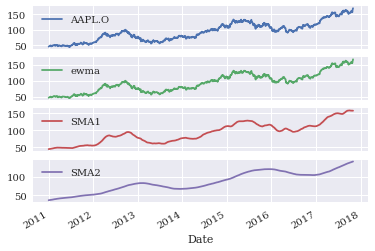

In [63]:
data_multivar.plot(subplots=True)

### Data Standarization

Let's use `StandardScaler` to perform data standarization. We take care of splitting x and y here so that we can predict later accordingly.

In [0]:
y = data_multivar['AAPL.O'].values

In [68]:
data_apple = data[['AAPL.O']]
data_apple

,AAPL.O
Date,
2010-12-31,46.079954
2011-01-03,47.081381
2011-01-04,47.327096
2011-01-05,47.714238
2011-01-06,47.675667
...,...
2017-10-25,156.410000
2017-10-26,157.410000
2017-10-27,163.050000


In [0]:
from sklearn.preprocessing import StandardScaler

multivar_scaler_x = StandardScaler()
multivar_scaler_y = StandardScaler()
data_multivar_scaled_x = multivar_scaler_x.fit_transform(data_multivar.values)
data_multivar_scaled_y = multivar_scaler_y.fit_transform(data_apple.values)

### Data split

In [70]:
# Create train split with 20%
train_split_finance = int(data['AAPL.O'].shape[0] - data['AAPL.O'].shape[0]*.2)
train_split_finance

1376

### Single Step Model

We will teach the model to predict a single point in the future, based on the history that we have. Remember, this will predict the stock price (since this has been our y). 

We then define our dataset. Our dataset samples the inputing features with a windowing task, and in this case we add the sampling of past observations based on the step size given.

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            # Appends a single point
            labels.append(target[i+target_size])
        else:
            # Appends a sequence until the target point
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

We will create a network that sees 30 days back and predicts a target 5 days ahead from the moment is predicting. The step controls whether we want to have it day by day, every other day, etc.

In [0]:
past_history = 30
future_target = 10
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset=data_multivar_scaled_x, 
                                                   target=data_multivar_scaled_y, 
                                                   start_index=0,
                                                   end_index=train_split_finance, 
                                                   history_size=past_history,
                                                   target_size=future_target, 
                                                   step=STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset=data_multivar_scaled_x, 
                                                   target=data_multivar_scaled_y, 
                                                   start_index=train_split_finance,
                                                   end_index=None, 
                                                   history_size=past_history,
                                                   target_size=future_target, 
                                                   step=STEP,
                                                   single_step=True)

Let's have a look at a single point

In [74]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (30, 4)


Let's look at the shape of it all

In [75]:
x_train_single.shape

(1346, 30, 4)

In [76]:
y_train_single.shape

(1346, 1)

#### Create the train, validation

In [0]:
BATCH_SIZE = 30
BUFFER_SIZE = 10

In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

#### Create the model



In [79]:
x_train_single.shape[-2:]

(30, 4)

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's look at the sample prediction

In [81]:
for x, y in val_data_single.take(1):
    print(y)
    print(single_step_model.predict(x).shape)

tf.Tensor(
[[0.51181734]
 [0.50718805]
 [0.51644663]
 [0.48834024]
 [0.4995828 ]
 [0.47246841]
 [0.45725789]
 [0.4364261 ]
 [0.43245815]
 [0.40534375]
 [0.40865039]
 [0.42948218]
 [0.46254851]
 [0.46155652]
 [0.4833803 ]
 [0.38947191]
 [0.31044338]
 [0.38682661]
 [0.4698231 ]
 [0.59613648]
 [0.72178854]
 [0.70029543]
 [0.65598654]
 [0.65565588]
 [0.65499455]
 [0.69037553]
 [0.62721884]
 [0.63284011]
 [0.63978404]
 [0.66822109]], shape=(30, 1), dtype=float64)
(30, 1)


#### Fit the model

In [0]:
EVALUATION_INTERVAL = 50
EPOCHS = 10

In [83]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=10)

Epoch 1/10
50/50 [==============================] - 1s 20ms/step - loss: 0.2474 - val_loss: 0.4812
Epoch 2/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1646 - val_loss: 0.5175
Epoch 3/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1583 - val_loss: 0.5309
Epoch 4/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1520 - val_loss: 0.4394
Epoch 5/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1454 - val_loss: 0.4611
Epoch 6/10
50/50 [==============================] - 1s 13ms/step - loss: 0.1384 - val_loss: 0.5038
Epoch 7/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1446 - val_loss: 0.2983
Epoch 8/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1386 - val_loss: 0.3230
Epoch 9/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1484 - val_loss: 0.4730
Epoch 10/10
50/50 [==============================] - 1s 12ms/step - loss: 0.1402 - val_loss: 0.4238


#### Visualizing the training

Remember... we do not have a lot of data...

In [0]:
hist_df = pd.DataFrame(single_step_history.history)

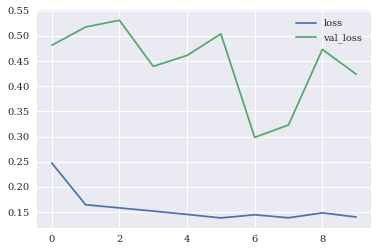

In [85]:
hist_df.plot()

#### Getting the real numbers again

⚠️ If we would have scaled `X` and use `Y` as `X[:,0]` we would have had problems here. Hence creating a scaled Y separately.

In [86]:
for x, y in val_data_single.take(1):
    gg = multivar_scaler_y.inverse_transform(single_step_model.predict(x)[0])
    print(gg)

[103.05204]


#### Plotting it all


In [87]:
x_val_single.shape[0] - 5 

300

In [88]:
val_data_single.skip(x_val_single.shape[0] - 5)

<SkipDataset shapes: ((None, 30, 4), (None, 1)), types: (tf.float64, tf.float64)>

Plotting without unscaling

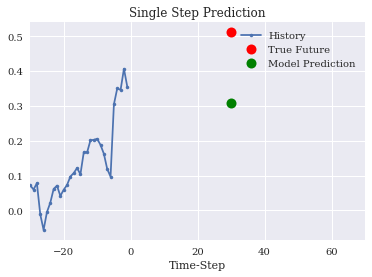

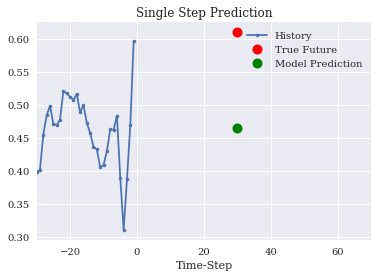

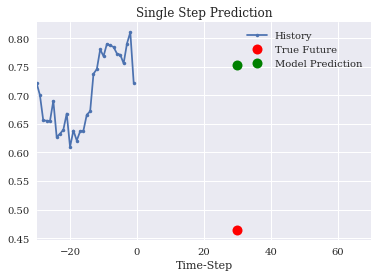

In [89]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 30, 'Single Step Prediction')
    plot.show()

Plotting with unscaling

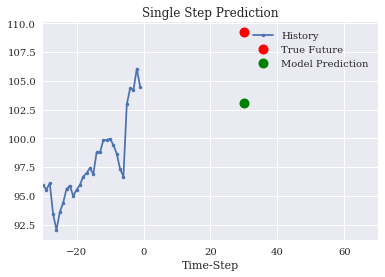

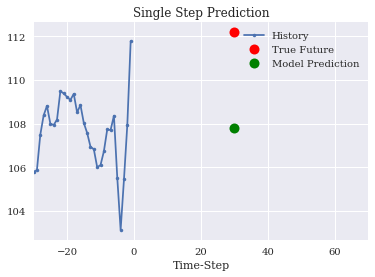

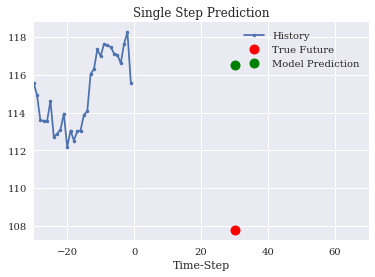

In [100]:
for x, y in val_data_single.take(3):
    x_plot = multivar_scaler_x.inverse_transform(x[0].numpy())
    y_plot = multivar_scaler_y.inverse_transform(y[0].numpy())
    pred = multivar_scaler_y.inverse_transform(single_step_model.predict(x)[0])

    plot = show_plot([x_plot[:,0], y_plot, pred], 30, 'Single Step Prediction')
    plot.show()

That's quite bad... we will need a lot more data if we need to make money or... try to predict on datasets that we know that have quite a good correlation...

### Multi-Step model

When we do a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Instead of predicting a single point in the future, we predict the sequence that leads to that point.

We will need to create the dataset again, with the step option as False.


#### Dataset Creation

In [0]:
past_history = 30
future_target = 10
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset=data_multivar_scaled_x, 
                                                   target=data_multivar_scaled_y, 
                                                   start_index=0,
                                                   end_index=train_split_finance, 
                                                   history_size=past_history,
                                                   target_size=future_target, 
                                                   step=STEP,
                                                   single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset=data_multivar_scaled_x, 
                                                   target=data_multivar_scaled_y, 
                                                   start_index=train_split_finance,
                                                   end_index=None, 
                                                   history_size=past_history,
                                                   target_size=future_target, 
                                                   step=STEP,
                                                   single_step=False)

Let's check the sample point

In [103]:
print ('Single window of past history (days): {}'.format(x_train_multi[0].shape))
print ('\n Target stockprice to predict (days): {}'.format(y_train_multi[0].shape))

Single window of past history (days): (30, 4)

 Target stockprice to predict (days): (10, 1)


#### Dataset creation

In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

#### Visualizing multi-step

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo-', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro-', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

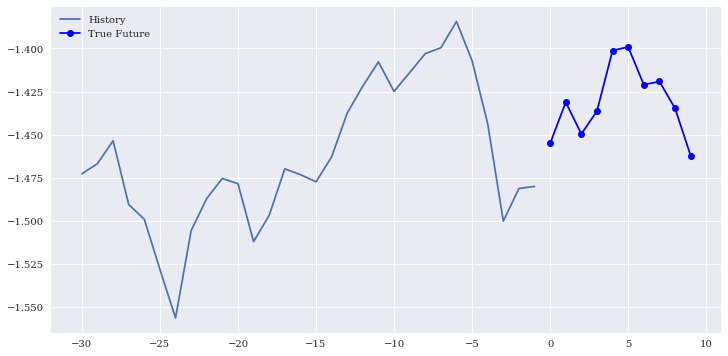

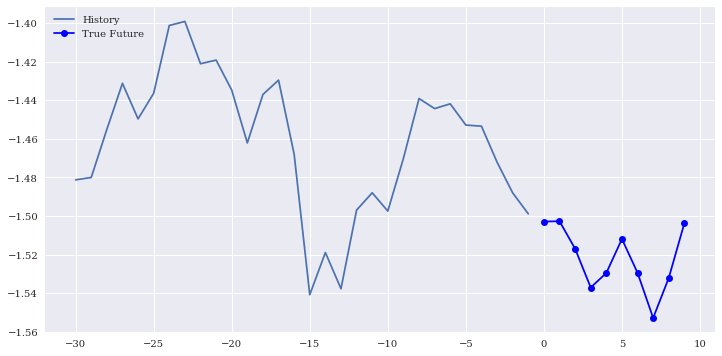

In [142]:
for x, y in train_data_multi.take(2):
    # Since our Dataset has shuffle, this will change all the time
    multi_step_plot(x[0], y[0], np.array([0]))

#### Create model

The task here ios slightly more complex. We can add two LSTM layers. 

⚠️ Beware! Our last layer should be as big as the `future_target`

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's check if this will predict (and how) before training

In [173]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(30, 10)


#### Training the model

In [0]:
EVALUATION_INTERVAL = 50
EPOCHS = 10

In [175]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
50/50 [==============================] - 2s 48ms/step - loss: 0.6178 - val_loss: 0.8024
Epoch 2/10
50/50 [==============================] - 2s 36ms/step - loss: 0.3645 - val_loss: 0.6528
Epoch 3/10
50/50 [==============================] - 2s 36ms/step - loss: 0.2974 - val_loss: 0.7146
Epoch 4/10
50/50 [==============================] - 2s 37ms/step - loss: 0.2785 - val_loss: 0.7608
Epoch 5/10
50/50 [==============================] - 2s 36ms/step - loss: 0.2424 - val_loss: 0.7418
Epoch 6/10
50/50 [==============================] - 2s 36ms/step - loss: 0.2194 - val_loss: 0.6575
Epoch 7/10
50/50 [==============================] - 2s 37ms/step - loss: 0.2254 - val_loss: 0.2650
Epoch 8/10
50/50 [==============================] - 2s 37ms/step - loss: 0.2125 - val_loss: 0.4087
Epoch 9/10
50/50 [==============================] - 2s 38ms/step - loss: 0.2027 - val_loss: 0.5391
Epoch 10/10
50/50 [==============================] - 2s 38ms/step - loss: 0.2164 - val_loss: 0.5357


#### Visualizing the results
Remember... we do not have a lot of data...

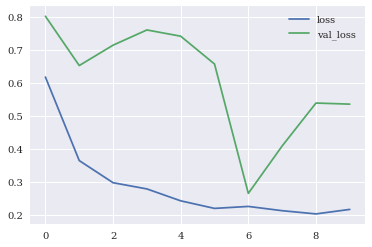

In [176]:
hist_df_multi = pd.DataFrame(multi_step_history.history)
hist_df_multi.plot()

#### Predict multi-steps

Predicting without unscaling

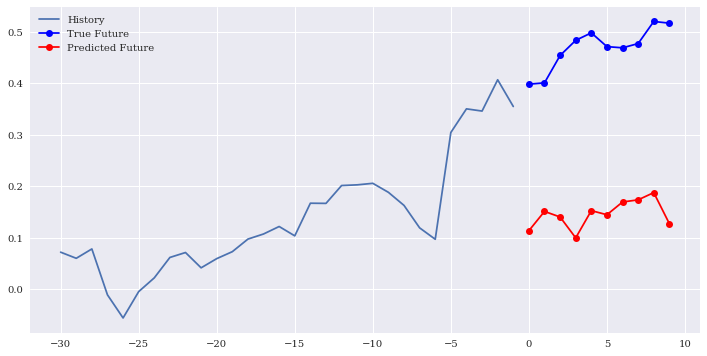

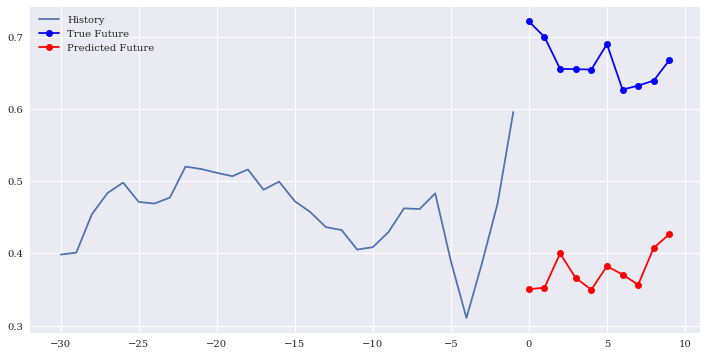

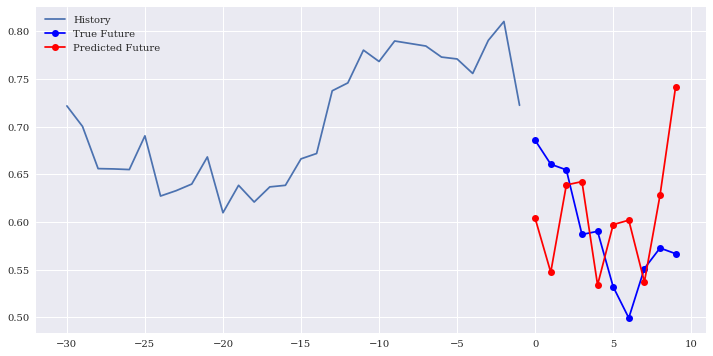

In [177]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

Predicting with unscaling

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo-', label='True Future')
    
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro-', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

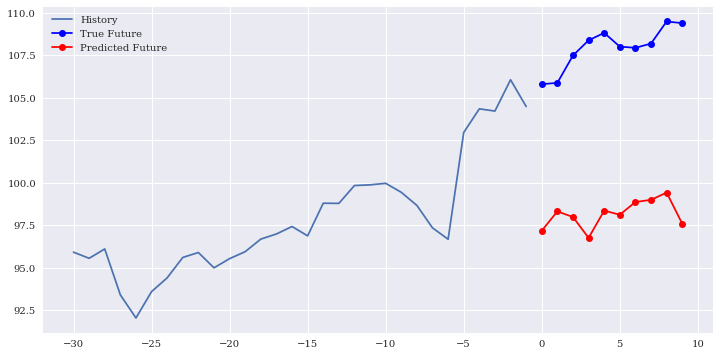

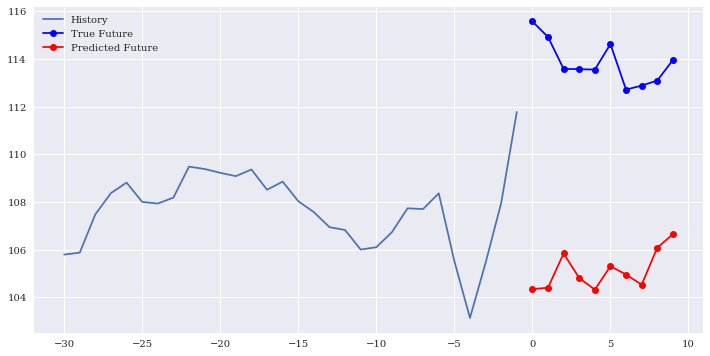

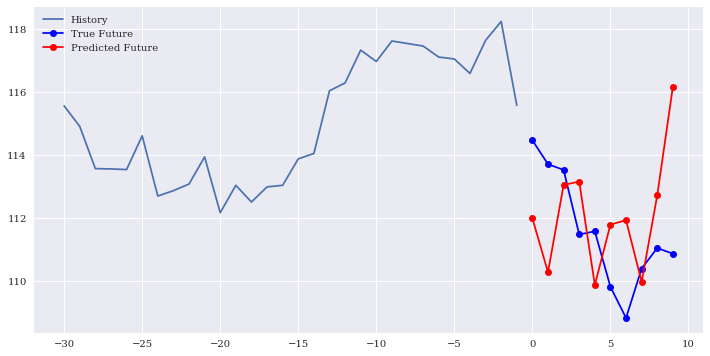

In [179]:
for x, y in val_data_multi.take(3):
    x_plot = multivar_scaler_x.inverse_transform(x[0].numpy())
    y_plot = multivar_scaler_y.inverse_transform(y[0].numpy())
    pred = multivar_scaler_y.inverse_transform(multi_step_model.predict(x)[0])

    multi_step_plot(x_plot, y_plot[:,0], pred)

Well, this was not super good. Perhaps we need to add more layers (remember to use  `return_sequences=True`), train longer or have more data.

## IN CLASS EXERCISE 3: multivariate time series

Try the multivariate time series with another stock symbol. Perhaps with the combination of S&P500 and VIX?

In [0]:
# Do your exercise here

# Further knowledge

RNNs took by storm the world of time series forecasting. Still, there are models like Auto Correlation Functions, Moving Averages, Auto Regressive Integrated Moving Average (ARIMA) that deals with stationary data. However, it might be interesting for your problem that the model actually "learns" that seasonality in order to predict better.